#**Install Packages**

In [ ]:
%%capture
!pip install super-gradients==3.2.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

#**Import libraries**

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

The console stream is logged into /root/sg_logs/console.log


[2024-05-19 16:25:16] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-05-19 16:25:24] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-05-19 16:25:31] INFO - utils.py - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2024-05-19 16:25:32] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-05-19 16:25:32] WARNING - export.py - Failed to import pytorch_quantization
[2024-05-19 16:25:33] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-05-19 16:25:33] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2024-05-19 16:25:33] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[20

In [ ]:
from IPython.display import clear_output


In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback



In [ ]:
from super_gradients.training import models


#**Setting checkpoint directory dan Inisiasi trainer**

In [ ]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='ppe_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

#**Expor Dataset dari Roboflow**

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="OUx13M4wAVBt0qeZboyR")
project = rf.workspace("project-uyrxf").project("ppe_detection-v1x3l")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to PPE_Detection-2 in yolov5pytorch::   0%|          | 0/6472 [00:00<?, ?it/s]

Extracting Dataset Version Zip to PPE_Detection-2 in yolov5pytorch::  93%|█████████▎| 6001/6472 [00:01<00:00, 5666.20it/s]

#**Load dataset parameters ke dictionary**

In [ ]:
dataset_params = {
    'data_dir':'/content/PPE_Detection-2',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Dust Mask', 'Eye Wear', 'Glove', 'Protective Boots', 'Protective Helmet', 'Safety Vest', 'Shield']
}


#**Pass the values for `dataset_params` into the `dataset_params` argument as shown below.**

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

#**Inspect the Dataset Defined Earlier**

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [ ]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [ ]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

Indexing dataset annotations: 100%|██████████| 322/322 [00:00<00:00, 3222.18it/s]


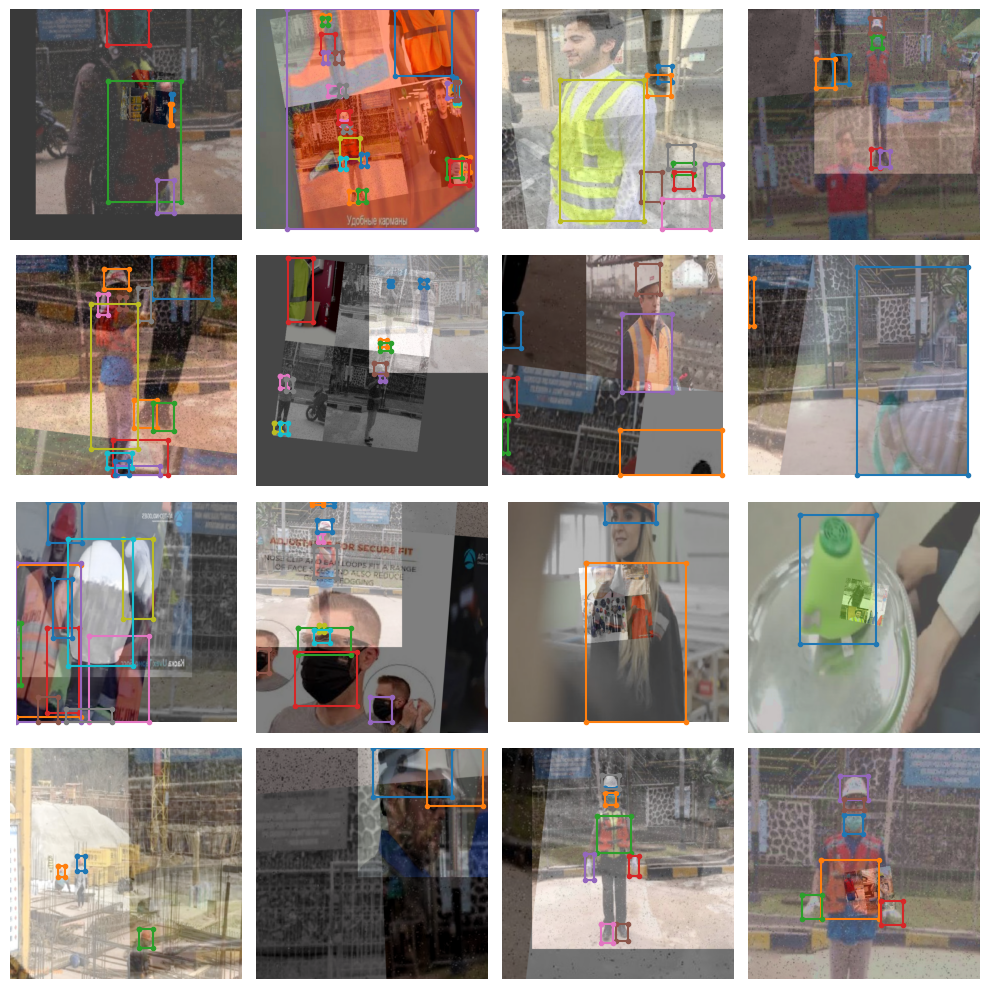

In [ ]:
train_data.dataset.plot()

#**Instantiating model**

In [ ]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-05-19 16:26:00] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:02<00:00, 38.1MB/s]
[2024-05-19 16:26:03] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


[2024-05-19 16:26:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


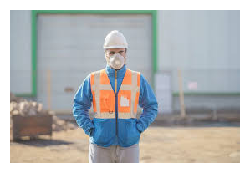

In [ ]:
model.predict("/content/apd.jpg").show()

#**Define metrics and training parameters**


In [ ]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 35,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

#**Training the model**



In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to checkpoints/ppe_yolonas_run/console_May19_16_26_07.txt


[2024-05-19 16:26:08] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[2024-05-19 16:26:16] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2271       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         141        (len(train_loader))
    - Gradient updates per epoch:   141        (len(train_loader) / batch_accumulate)

[2024-05-19 16:29:43] INFO - base_sg_logger.py - Che

#**Get trained model**

In [ ]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints/ppe_yolonas_run/ckpt_best.pth")

#**Evaluating the best trained model on the test set**

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

#**Predicting with the best model**



[2024-05-15 08:19:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


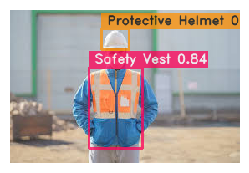

In [ ]:
img_url = '/content/apd.jpg'
best_model.predict(img_url).show()

#**Testing on Video 1**

In [ ]:
input_video_path = f"/content/Untitled video - Made with Clipchamp (2).mp4"
output_video_path = "detections1.mp4"

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 125/125 [00:01<00:00, 70.77it/s]


#**Display the Output Video**

In [ ]:
!rm '/content/result_compressed.mp4'

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections1.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)